# Lab 05: Deep Q-Network in Pytorch

Step 01: Define environment

In [151]:
# import packages
import gym 
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt

# prepare environment
env = gym.make("CartPole-v1").env
env.reset()
# number of states
state_dim = env.observation_space.shape
print("#states = ", state_dim)

# number of actions
n_actions = env.action_space.n 
print("#actions = ", n_actions)


#states =  (4,)
#actions =  2


Step 02: Create Q-network

In [152]:
import torch 
import torch.nn as nn

# define class of Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim[0], 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, n_actions)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)        

        return x
    
    def predict(self, state):
        # convert state variable to torch tensor
        state = torch.tensor(state, dtype = torch.float32)
        state = state.unsqueeze(0)  # add batch dimension
        # make prediction
        with torch.no_grad():
            q_values = self.forward(state)

        return q_values.numpy().flatten()

In [153]:
# initialize q-network
qnet = QNetwork(state_dim, n_actions)
qnet

QNetwork(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)

Test predictions

In [154]:
# take the initial state
s = env.reset()
print("initial state = ", s[0])

# test prediction for initial state
example_state = s
example_pred = qnet.predict(example_state[0])
print("Predicted q-values = ", example_pred)

initial state =  [ 0.00567684 -0.0295081  -0.01180258 -0.03759454]
Predicted q-values =  [-0.10537921 -0.13273744]


In [155]:
# function to take action with epsilon-greedy policy

def get_action(state, epsilon=0):
    # calculate q-value
    q_values = qnet.predict(state)

    # if random parameter is better, take random action
    if np.random.rand() < epsilon:
        action = np.random.choice(len(q_values))
    # else, take the best action related with the highest Q(s, a)
    else:
        action = np.argmax(q_values)
    
    return action

Testing current values in environment

In [156]:
# test the function get action
a_test = get_action(s[0], epsilon = 0)
print("take the action for initial state: ", a_test) 

# current state
current_state = s[0]
print("current state = ", current_state)

# action 
print("action = ", a_test)

# next state
next_state, r, done, _, _ = env.step(a_test)
print("next state = ", next_state)

# reward
print("reward = ", r)

# final state?
print("is final state = ", done)


take the action for initial state:  0
current state =  [ 0.00567684 -0.0295081  -0.01180258 -0.03759454]
action =  0
next state =  [ 0.00508668 -0.22445883 -0.01255447  0.2513413 ]
reward =  1.0
is final state =  False


In [157]:
# function to convert environment variables to tensor
def convert_env_to_tensor(s, a, r, next_s, done):
    s = torch.as_tensor(s, dtype = torch.float32).unsqueeze(0)
    a = torch.as_tensor(a, dtype = torch.int64).unsqueeze(0)
    r = torch.as_tensor(r, dtype = torch.float32).unsqueeze(0)
    next_s = torch.as_tensor(next_s, dtype = torch.float32).unsqueeze(0)
    done = torch.as_tensor(done, dtype = torch.bool).unsqueeze(0)

    return s, a, r, next_s, done

In [158]:
# test conversion of variables to tensor
current_state, a_test, r, next_state, done = convert_env_to_tensor(current_state, a_test, r, next_state, done)

In [159]:
# current state and this prediction
print(current_state)
print(qnet(current_state))

# next-state and this prediction
print(next_state)
print(qnet(next_state))

tensor([[ 0.0057, -0.0295, -0.0118, -0.0376]])
tensor([[-0.1054, -0.1327]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0051, -0.2245, -0.0126,  0.2513]])
tensor([[-0.1096, -0.1324]], grad_fn=<AddmmBackward0>)


In [160]:
# test
assert isinstance(qnet.fc3, torch.nn.Linear)

In [161]:
# test epsilon-greedy condition
s = env.reset()
s = s[0]

for eps in [0.0, 0.1, 0.5, 1.0]:
    state_freq = np.zeros(n_actions, dtype = int)

    for i in range(10000):
        action = get_action(s, epsilon = eps)
        state_freq[action] += 1

    best_action = np.argmax(state_freq)
    
    assert abs(state_freq[best_action] - 10000 * (1 - eps + eps/n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_freq[other_action] - 10000 * (eps/n_actions)) < 200
            
    print('epsilon=%.1f tests passed'%eps)

epsilon=0.0 tests passed
epsilon=0.1 tests passed
epsilon=0.5 tests passed
epsilon=1.0 tests passed


Step 03: Integrate Q-Learning with Gradient Descendent

Loss Function:  
  
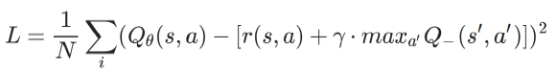
  
Where:  
s: current state  
a: action  
r: reward  
s': next state  
gamma: discount factor  
Q_theta(s, a): result of Q-value given chosed politic by neural network  
Q-: max{a}{Q(s', a')}: is the max Q-value for the next state s_t+1 over all possible actions

In [162]:
state_dim

(4,)

In [163]:
# Add batch dimension to testing with random values
states_ph = torch.empty((1,) + state_dim, dtype=torch.float32)  
actions_ph = torch.empty((1,), dtype=torch.int64) 
rewards_ph = torch.empty((1,), dtype=torch.float32)
next_states_ph = torch.empty((1,) + state_dim, dtype=torch.float32)
is_done_ph = torch.empty((1,), dtype=torch.bool)

In [164]:
# setting q-values for all actions in the current state
# calculate Q_theta(s, a) from Q-network
pred_qvalues = qnet(states_ph)

# clip actions_ph to stay between [0, n_actions -1]
actions_ph = torch.clamp(actions_ph, 0, n_actions-1)

# one-hot encode for actions_ph tensor
actions_oh = torch.nn.functional.one_hot(actions_ph, n_actions).to(torch.float32)

# calculate predicted q-values for actions
pred_qvalues_x_actions = torch.sum(pred_qvalues * actions_oh, dim = 1)
print(pred_qvalues_x_actions)

tensor([-0.1032], grad_fn=<SumBackward1>)


In [165]:
print("initial states = ", states_ph)
print("predicted q-value = ", qnet(states_ph))
print("next states = ", next_states_ph)
print("predicted q-value = ", qnet(next_states_ph))
print("actions = ", actions_ph)

initial states =  tensor([[-0.1059, -0.1320, -0.0018,  0.0150]])
predicted q-value =  tensor([[-0.1032, -0.1323]], grad_fn=<AddmmBackward0>)
next states =  tensor([[-0.0050, -0.0410, -0.0018,  0.0150]])
predicted q-value =  tensor([[-0.1059, -0.1320]], grad_fn=<AddmmBackward0>)
actions =  tensor([0])


In [166]:
gamma = 0.99

# apply NN to obtain Q-values for next states
pred_next_qvalues = qnet(next_states_ph)

# calculate V*(next_states) using the predicted next Q-values 
# V*(s') = max{a}Q*(s, a)
next_state_values, _ = torch.max(pred_next_qvalues, dim = 1)

# calculate formula of loss function
# loss = 1/N * sum{( Q(si, ai) - [ri + gamma * max{a'}Q(s_i+1, a')] )**2}
# where target_q-value = ri + gamma * max{a'}Q(s_i+1, a')
target_qvalues_x_actions = rewards_ph + gamma * next_state_values
print(target_qvalues_x_actions)

# in the last state use the formula Q(s, a) = r(s, a), 
# given the fact that don't exist next state
target_qvalues_x_actions = torch.where(is_done_ph, rewards_ph, target_qvalues_x_actions)


tensor([-0.2107], grad_fn=<AddBackward0>)


In [167]:
# define MSE-loss function
loss = (pred_qvalues_x_actions - target_qvalues_x_actions.detach())**2
loss = torch.mean(loss)

In [168]:
# check the loss
print(loss)

tensor(0.0116, grad_fn=<MeanBackward0>)


Step 04: Playing with Q-Network

In [169]:
# define optimizer algorithm
import torch.optim as optim 

optimizer = optim.Adam(qnet.parameters(), lr = 1e-4)

In [170]:
def calculate_reward(env, t_max = 1000, epsilon = 0, train = False):

    # define the total reward
    total_reward = 0

    # take the initial state
    s = env.reset()    
    s  = s[0]

    for t in range(t_max):

        # take the action
        a = get_action(s, epsilon)
        
        # check the next step
        next_s, r, done, _, _ = env.step(a)

        if train:            
            # convert all env-variables to torch tensor
            s, a, r, next_s, done = convert_env_to_tensor(s, a, r, next_s, done)

            # calculate Q_theta
            pred_qvalues = qnet(s)                    
            actions_ph = torch.clamp(a, 0, n_actions-1)
            actions_oh = torch.nn.functional.one_hot(actions_ph, n_actions).to(torch.float32)                
            pred_qvalues_x_actions = torch.sum(pred_qvalues * actions_oh, dim = 1)
            
            # calculate Q-target
            pred_next_qvalues = qnet(next_s)            
            next_state_values, _ = torch.max(pred_next_qvalues, dim = 1)
            target_qvalues_x_actions = r + gamma * next_state_values
            target_qvalues_x_actions = torch.where(done, r, target_qvalues_x_actions)
            loss = torch.mean((pred_qvalues_x_actions - target_qvalues_x_actions.detach())**2)            
            loss.backward()
            optimizer.step()

        # accumulate the reward
        total_reward += r

        # advance to next state
        s = next_s

        if done:
            break
    
    return total_reward


In [171]:
epsilon = 0.5

for i in range(1000):    
    tot_rewards = [calculate_reward(env, t_max = 1000, epsilon = epsilon, train = True)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(tot_rewards), epsilon))
    epsilon *= 0.99
    assert epsilon >= 1e-4

    if np.mean(tot_rewards) > 300:
        print("You Win!")
        break    

C:\Users\HP\AppData\Local\Temp\ipykernel_13668\635027586.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype = torch.float32)


epoch #0	mean reward = 9.000	epsilon = 0.500
epoch #1	mean reward = 14.000	epsilon = 0.495
epoch #2	mean reward = 12.000	epsilon = 0.490
epoch #3	mean reward = 9.000	epsilon = 0.485
epoch #4	mean reward = 10.000	epsilon = 0.480
epoch #5	mean reward = 10.000	epsilon = 0.475
epoch #6	mean reward = 10.000	epsilon = 0.471
epoch #7	mean reward = 11.000	epsilon = 0.466
epoch #8	mean reward = 12.000	epsilon = 0.461
epoch #9	mean reward = 14.000	epsilon = 0.457
epoch #10	mean reward = 13.000	epsilon = 0.452
epoch #11	mean reward = 12.000	epsilon = 0.448
epoch #12	mean reward = 17.000	epsilon = 0.443
epoch #13	mean reward = 10.000	epsilon = 0.439
epoch #14	mean reward = 13.000	epsilon = 0.434
epoch #15	mean reward = 9.000	epsilon = 0.430
epoch #16	mean reward = 19.000	epsilon = 0.426
epoch #17	mean reward = 10.000	epsilon = 0.421
epoch #18	mean reward = 10.000	epsilon = 0.417
epoch #19	mean reward = 11.000	epsilon = 0.413
epoch #20	mean reward = 11.000	epsilon = 0.409
epoch #21	mean reward = 12